In [ ]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
path = '/content/drive/MyDrive/my/CIC-IDS2017'
all_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

In [ ]:
print(f"Found {len(all_files)} files. Loading and merging...")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

Found 8 files. Loading and merging...


In [ ]:
# Remove whitespace from headers
df.columns = df.columns.str.strip()

In [ ]:
df.shape

(2830743, 79)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.isna().sum()

,0
Destination Port,0
Flow Duration,0
Total Fwd Packets,0
Total Backward Packets,0
Total Length of Fwd Packets,0
...,...
Idle Mean,0
Idle Std,0
Idle Max,0
Idle Min,0


In [ ]:
df.isna().sum()[df.isna().sum() > 0]

,0
Flow Bytes/s,2867
Flow Packets/s,2867


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(2827876, 79)

In [ ]:
df.isna().sum()[df.isna().sum() > 0]

,0


In [ ]:
np.isinf(df.select_dtypes(include=np.number)).values.any()

np.False_

In [ ]:
df['Label'].value_counts()

,count
Label,
BENIGN,2271320
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [ ]:
df['Binary_Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
df['Binary_Label'].value_counts()

,count
Binary_Label,
0,2271320
1,556556


In [ ]:
X = df.drop(['Label', 'Binary_Label'], axis=1)
y = df['Binary_Label']

In [ ]:
X_dev, _, y_dev, _ = train_test_split(X, y, train_size=0.10, stratify=y, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2, stratify=y_dev, random_state=42)

In [ ]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
to_drop

['Total Backward Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Std',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Fwd IAT Total',
 'Fwd IAT Max',
 'Fwd Packets/s',
 'Max Packet Length',
 'Packet Length Std',
 'SYN Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Average Packet Size',
 'Avg Fwd Segment Size',
 'Avg Bwd Segment Size',
 'Fwd Header Length.1',
 'Subflow Fwd Packets',
 'Subflow Fwd Bytes',
 'Subflow Bwd Packets',
 'Subflow Bwd Bytes',
 'act_data_pkt_fwd',
 'min_seg_size_forward',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [ ]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)
print(f"Dropped {len(to_drop)} redundant features based on high correlation.")

Dropped 26 redundant features based on high correlation.


In [ ]:
X_train.shape

(226229, 52)

In [ ]:
X_test.shape

(56558, 52)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [ ]:
X_train_scaled.shape

(226229, 52)

In [ ]:
X_train_res.shape

(363410, 52)

In [ ]:
y_train_res.shape

(363410,)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

performance = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test_scaled)
    duration = time.time() - start

    performance.append({
        "Model": name,
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "Time": duration
    })

perf_df = pd.DataFrame(performance)
print("\n--- Final Results ---")
print(perf_df)


--- Final Results ---
                 Model  Precision    Recall        F1       Time
0  Logistic Regression   0.698401  0.953643  0.806305  15.412890
1        Random Forest   0.996854  0.996406  0.996630  73.635918
2              XGBoost   0.996685  0.999461  0.998071   6.789384


Best Model:XGBoost

In [ ]:
best_model_name = "XGBoost"
cm = confusion_matrix(y_test, models[best_model_name].predict(X_test_scaled))
cm=pd.DataFrame(cm)
cm

,0,1
0,45390,37
1,6,11125


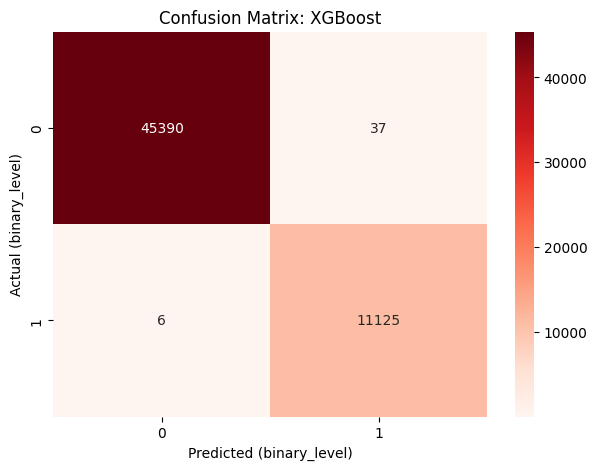

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted (binary_level)")
plt.ylabel("Actual (binary_level)")
plt.show()

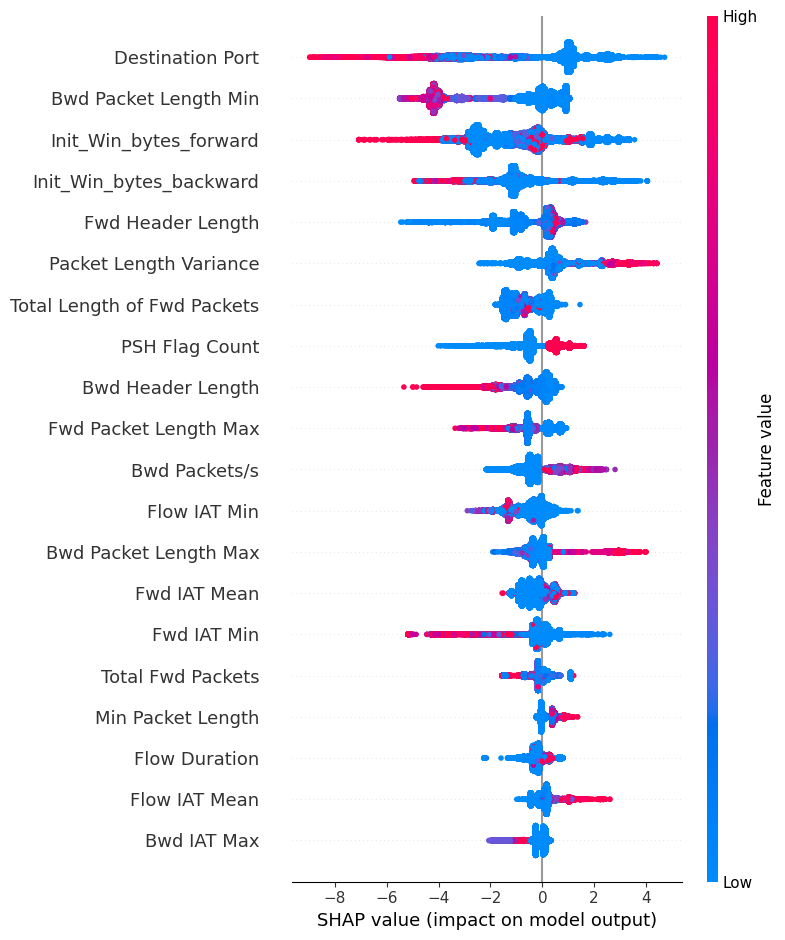

In [ ]:
import shap

explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test)

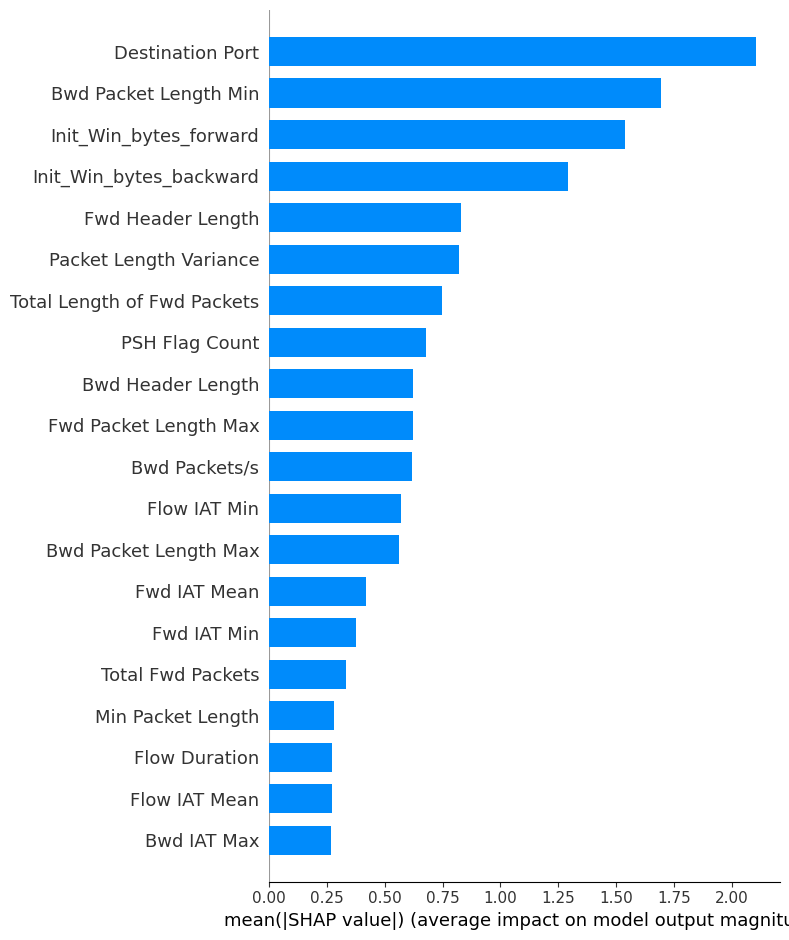

In [ ]:
# Bar plot instead of dot plot
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar"
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Define the Architecture
# Input shape is the number of features in your X_train_res
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.2), # Prevents overfitting
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Binary output: 0 or 1
])

# 2. Compile
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

# 3. Train
# We use a small validation split to monitor performance during training
history = model_nn.fit(
    X_train_res, y_train_res,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9122 - loss: 0.2151 - recall: 0.8630 - val_accuracy: 0.9817 - val_loss: 0.0868 - val_recall: 0.9817
Epoch 2/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9643 - loss: 0.0923 - recall: 0.9642 - val_accuracy: 0.9850 - val_loss: 0.0849 - val_recall: 0.9850
Epoch 3/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9700 - loss: 0.0791 - recall: 0.9725 - val_accuracy: 0.9881 - val_loss: 0.0679 - val_recall: 0.9881
Epoch 4/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9722 - loss: 0.0711 - recall: 0.9763 - val_accuracy: 0.9814 - val_loss: 0.0646 - val_recall: 0.9814
Epoch 5/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9734 - loss: 0.0678 - recall: 0.9787 - val_accuracy: 0.9886 - val_loss: 0.0591 - val_recall: 0.9886
Epoch 6/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9740 - loss: 0.0656 - recall: 0.9801 - val_accuracy: 0.9890 - val_loss: 0.0652 - val_recall

In [ ]:
# Get predictions (NN outputs probabilities between 0 and 1)
nn_probs = model_nn.predict(X_test_scaled)
nn_preds = (nn_probs > 0.5).astype(int)

print("--- Neural Network Results ---")
print(classification_report(y_test, nn_preds))

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
--- Neural Network Results ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     45427
           1       0.89      0.99      0.94     11131

    accuracy                           0.97     56558
   macro avg       0.94      0.98      0.96     56558
weighted avg       0.98      0.97      0.97     56558



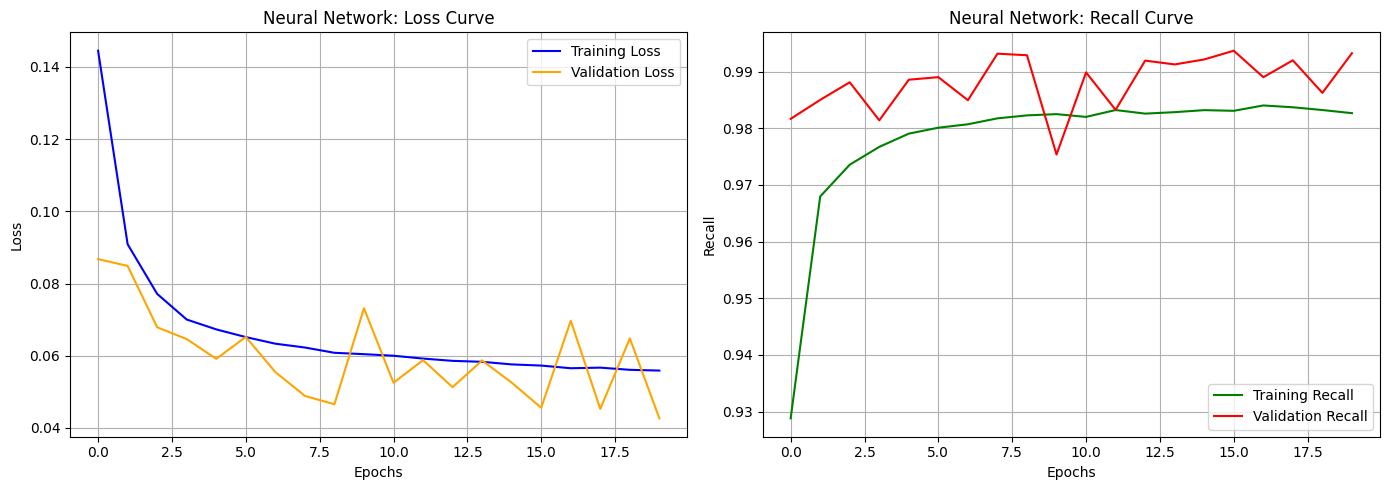

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots: Loss and Accuracy
plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Neural Network: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Recall (or Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Training Recall', color='green')
plt.plot(history.history['val_recall'], label='Validation Recall', color='red')
plt.title('Neural Network: Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

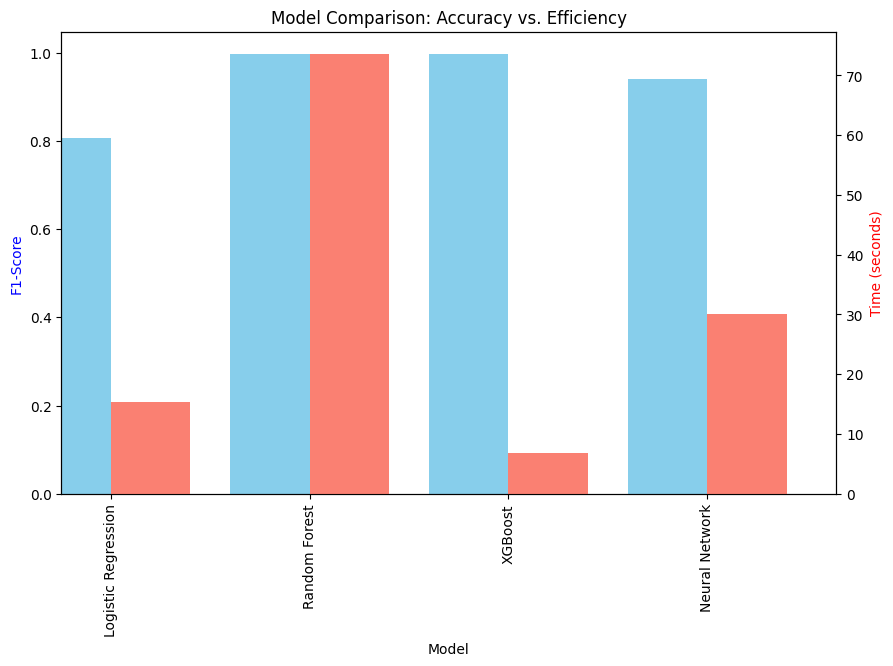

In [ ]:
import matplotlib.pyplot as plt

# Adding Neural Network results to your dataframe for comparison
nn_f1 = 0.94 # from your output
nn_time = 30 # estimate based on your epochs
new_row = {'Model': 'Neural Network', 'Precision': 0.89, 'Recall': 0.99, 'F1': nn_f1, 'Time': nn_time}
perf_df = pd.concat([perf_df, pd.DataFrame([new_row])], ignore_index=True)

# Plotting F1-Score vs Time
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
perf_df.plot(x='Model', y='F1', kind='bar', ax=ax1, color='skyblue', position=1, width=0.4, legend=False)
perf_df.plot(x='Model', y='Time', kind='bar', ax=ax2, color='salmon', position=0, width=0.4, legend=False)

ax1.set_ylabel('F1-Score', color='blue')
ax2.set_ylabel('Time (seconds)', color='red')
plt.title('Model Comparison: Accuracy vs. Efficiency')
plt.show()

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model
models["XGBoost"].save_model('models/best_xgboost_model.json')

# Save the scaler (Very important! You must use the same scaler for new data)
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
